In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
# sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/TCSA_SNN')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs
    )

import resnet_2_copy

from datetime import datetime
import glob
import random
# from fvcore.nn import FlopCountAnalysis
# from thop import profile
# from ptflops import get_model_complexity_info

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2_copy.resnet34().to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 4, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 4, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 4, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12           [32, 4, 1, 1, 1]               0
           Conv3d-13           [32, 1, 1, 1, 1]               4
             ReLU-14           [32, 1, 

In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation.zip"
extract_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted"

# # Extract ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['Modified_3_Brain_Tumor_Segmentation']

In [5]:
IMG_DIR      =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [10]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3
Batch_size  = 32
num_epochs  = 20
num_workers = 4
IMAGE_HEIGHT = 256 # 256 -> 512 originally
IMAGE_WIDTH  = 256 # 256 -> 512 originally
PIN_MEMORY = True
LOAD_MODEL = True
CHECKPOINT_NAME = "Att_Res_SNN_checkpoint_18_2025-04-26_09-13-27.pth.tar"

In [11]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device)

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

    nasar = model.calculate_nasar()

    return running_loss/len(loader), nasar

In [12]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2_copy.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_loss, nasar = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        val_acc, val_dice = check_accuracy(val_loader, model, device=Device)

        train_losses.append(train_loss)
        val_accs.append(val_acc.cpu().item())
        val_dice_scores.append(val_dice.cpu().item())
        train_nasar.append(nasar)

        scheduler.step(val_dice)
        print(f"Epoch {epoch}: LR = {optimizer.param_groups[0]['lr']}")

        checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        }

        checkpoint_filename = save_checkpoint(checkpoint, is_best=len(val_dice_scores) == 1 or val_dice_scores[-1] > max(val_dice_scores[:-1]))

        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader,
                model,
                checkpoint_filename=checkpoint_filename,
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                train_nasar=train_nasar,
                folder="Att_Res_SNN_saved_images/",
                device=Device,
                show_last_epoch=False,
            )
        else:
            save_predictions_as_imgs(
                val_loader,
                model,
                checkpoint_filename=checkpoint_filename,
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                train_nasar=train_nasar,
                folder="Att_Res_SNN_saved_images/",
                device=Device,
                show_last_epoch=True,
            )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Loaded checkpoint: Att_Res_SNN_checkpoint_18_2025-04-26_09-13-27.pth.tar
Got 29078348/29360128 with acc  99.04
Dice score: 0.735589325428009


100%|██████████| 82/82 [08:00<00:00,  5.86s/it, loss=0.0141]

NASAR: 0.15794418227504675


Got 28932605/29360128 with acc  98.54
Dice score: 0.4004165232181549
Epoch 0: LR = 0.0009960491453248291
✅ Checkpoint saved: Att_Res_SNN_checkpoint_19_2025-04-29_03-21-54.pth.tar


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0342]

NASAR: 0.1472752441262975


Got 28969457/29360128 with acc  98.67
Dice score: 0.5187163949012756
Epoch 1: LR = 0.00099337572429697
✅ Checkpoint saved: Att_Res_SNN_checkpoint_20_2025-04-29_03-25-19.pth.tar


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0174]

NASAR: 0.1496832852072559


Got 29055580/29360128 with acc  98.96
Dice score: 0.6838317513465881
Epoch 2: LR = 0.0009885061010232675
✅ Checkpoint saved: Att_Res_SNN_checkpoint_21_2025-04-29_03-28-44.pth.tar


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0119]

NASAR: 0.15172814203539925


Got 29029104/29360128 with acc  98.87
Dice score: 0.5948798656463623
Epoch 3: LR = 0.0009912936944618455
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0166]

NASAR: 0.15012142020212094


Got 29003152/29360128 with acc  98.78
Dice score: 0.5991820096969604
Epoch 4: LR = 0.0009911676846734634
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0166]

NASAR: 0.15473482194640828


Got 29080656/29360128 with acc  99.05
Dice score: 0.7305501103401184
Epoch 5: LR = 0.0009868890958882096
✅ Checkpoint saved: Att_Res_SNN_checkpoint_22_2025-04-29_03-38-57.pth.tar


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0169]

NASAR: 0.13440668526949456


Got 29053211/29360128 with acc  98.95
Dice score: 0.6516530513763428
Epoch 6: LR = 0.0009895586811089875
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0139]

NASAR: 0.147977524520086


Got 29023705/29360128 with acc  98.85
Dice score: 0.635981023311615
Epoch 7: LR = 0.0009900532111576407
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0149]

NASAR: 0.136784853509894


Got 29059122/29360128 with acc  98.97
Dice score: 0.6883774399757385
Epoch 8: LR = 0.0009883533843958704
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0168]

NASAR: 0.1355184814739675


Got 29015973/29360128 with acc  98.83
Dice score: 0.6037983894348145
Epoch 9: LR = 0.0009910314744407947
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0169]

NASAR: 0.14377704136808153


Got 29083397/29360128 with acc  99.06
Dice score: 0.7337237000465393
Epoch 10: LR = 0.00098677544462101
✅ Checkpoint saved: Att_Res_SNN_checkpoint_23_2025-04-29_03-55-58.pth.tar


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.02]

NASAR: 0.13705542837510087


Got 29101770/29360128 with acc  99.12
Dice score: 0.7731581926345825
Epoch 11: LR = 0.00098532290059204
✅ Checkpoint saved: Att_Res_SNN_checkpoint_24_2025-04-29_03-59-24.pth.tar


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0186]

NASAR: 0.12962416527976453


Got 29022675/29360128 with acc  98.85
Dice score: 0.5871196985244751
Epoch 12: LR = 0.0009915187182152594
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0141]

NASAR: 0.12972286385549625


Got 29060416/29360128 with acc  98.98
Dice score: 0.6696247458457947
Epoch 13: LR = 0.0009889769812835277
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0141]

NASAR: 0.1344225887961231


Got 29097372/29360128 with acc  99.11
Dice score: 0.7244970798492432
Epoch 14: LR = 0.0009871045249891628
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0133]

NASAR: 0.14040295954601306


Got 29096444/29360128 with acc  99.10
Dice score: 0.7340573668479919
Epoch 15: LR = 0.0009867634684177832
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0165]

NASAR: 0.12673441569010416


Got 29091405/29360128 with acc  99.08
Dice score: 0.7517597079277039
Epoch 16: LR = 0.0009861203552369528
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=0.0135]

NASAR: 0.1254776162160954


Got 29089542/29360128 with acc  99.08
Dice score: 0.7480127811431885
Epoch 17: LR = 0.0009862577345450252
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.012]

NASAR: 0.1289967460811418


Got 29087470/29360128 with acc  99.07
Dice score: 0.7184777855873108
Epoch 18: LR = 0.00098731700541646
 Checkpoint not saved as best model.


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0137]

NASAR: 0.13036152118808228


Got 29089675/29360128 with acc  99.08
Dice score: 0.7568191289901733
Epoch 19: LR = 0.0009859337877618625
 Checkpoint not saved as best model.


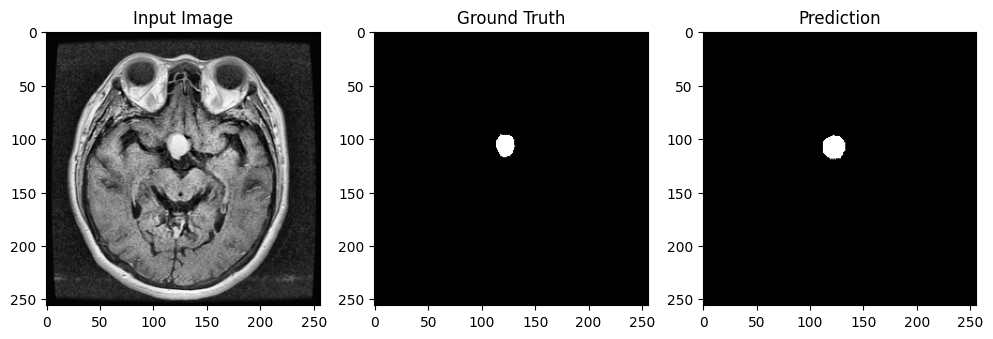

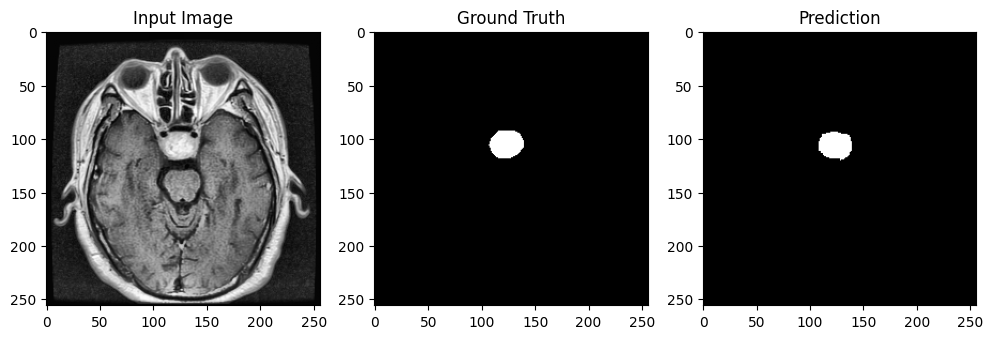

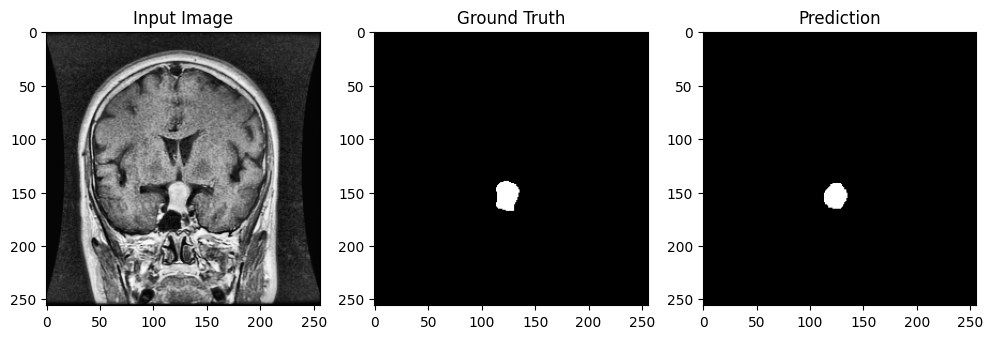

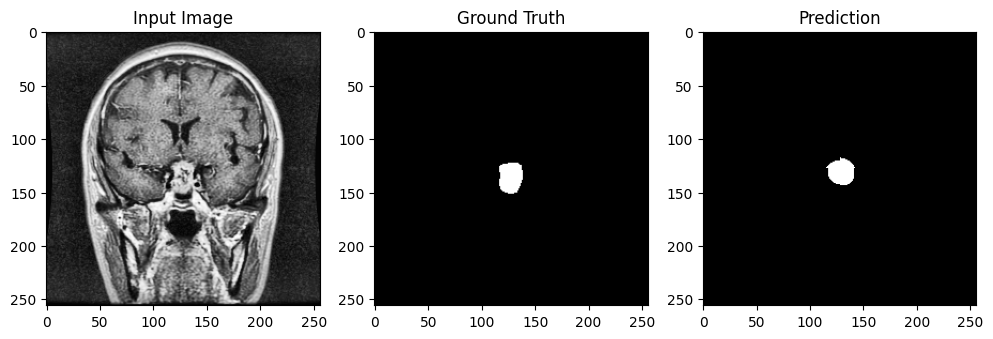

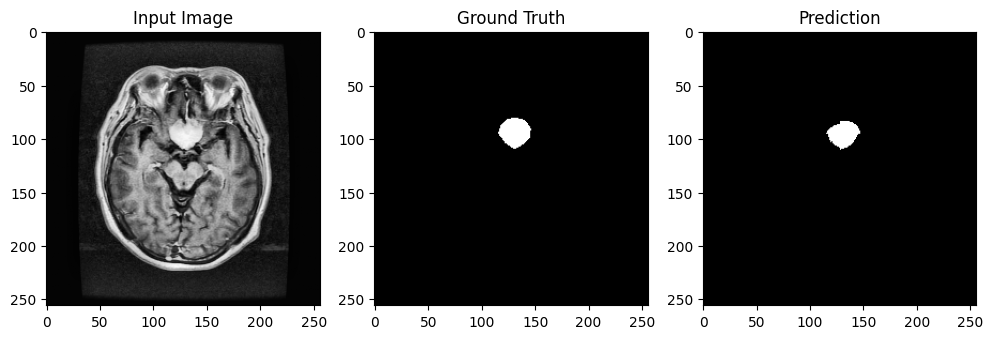

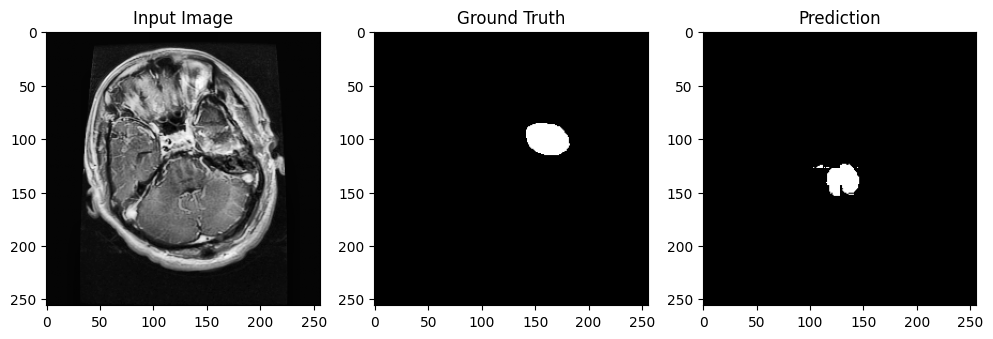

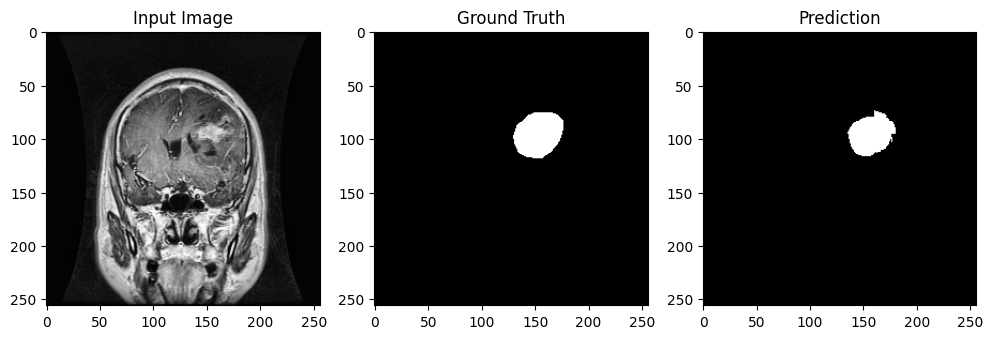

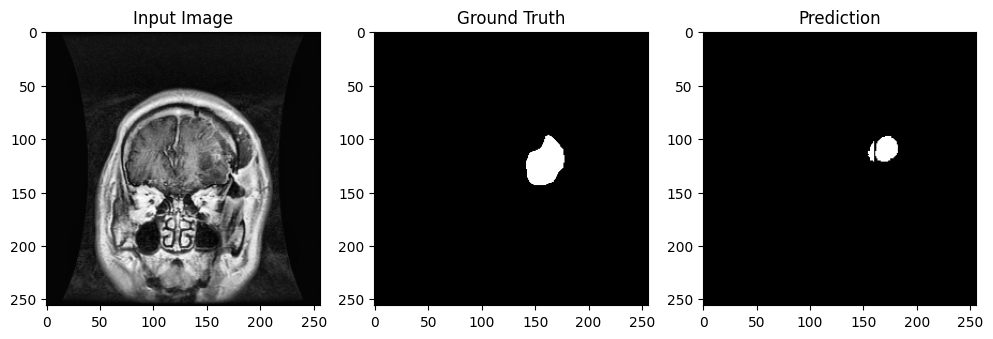

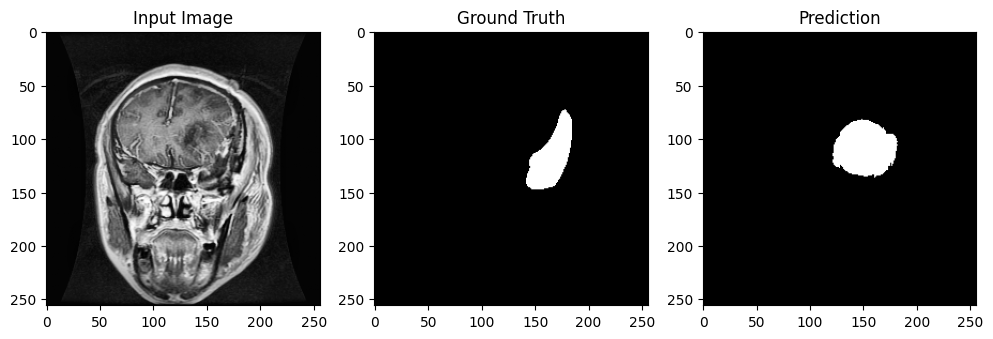

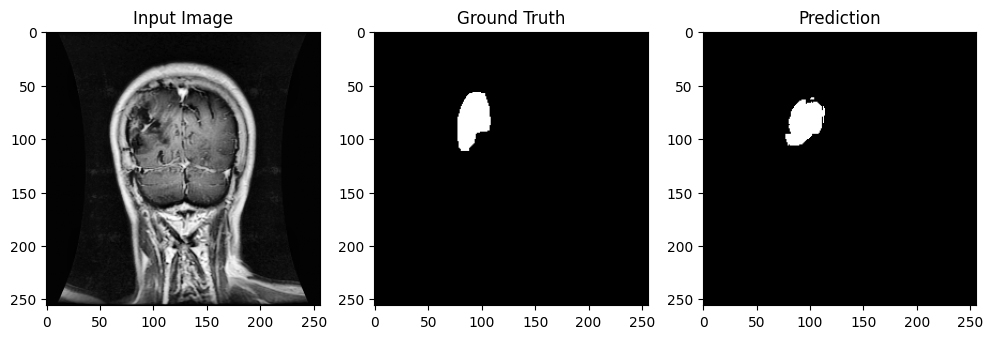

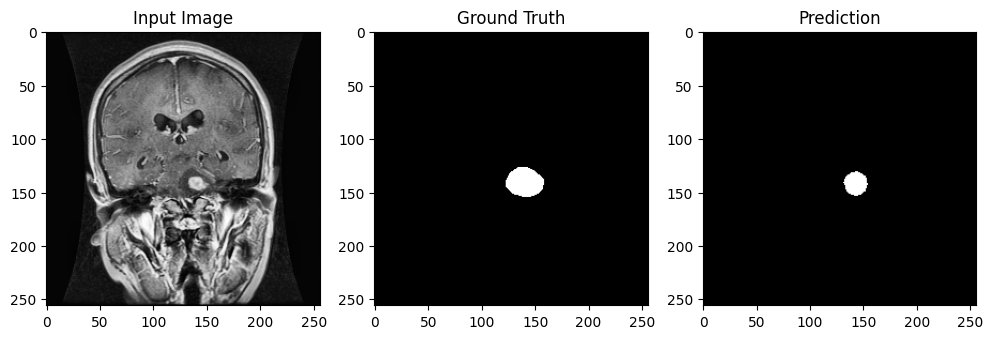

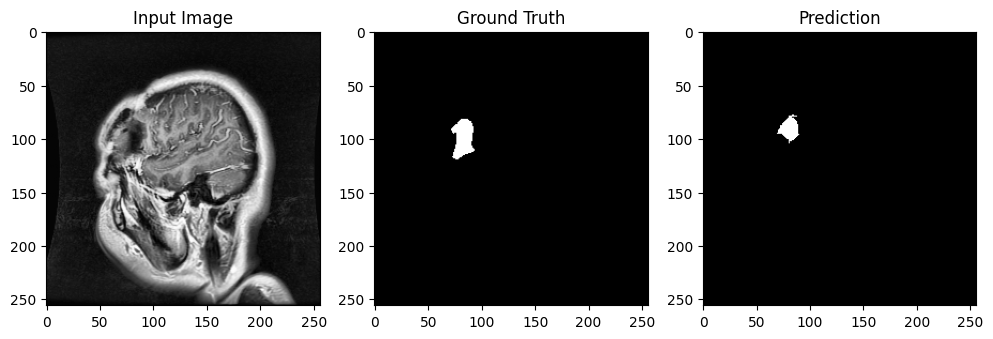

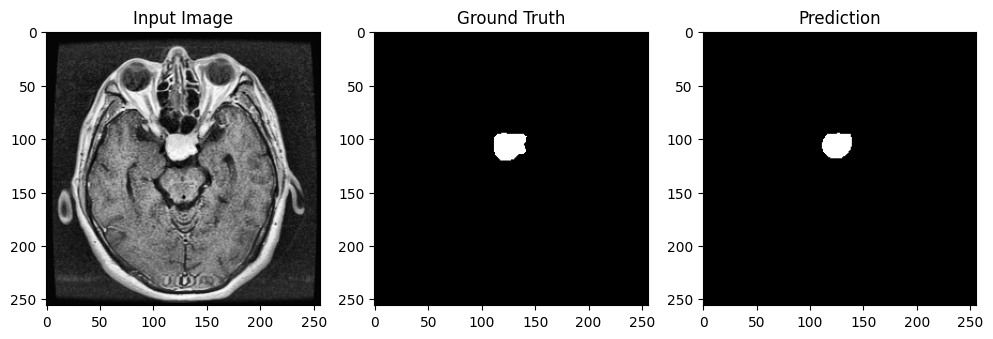

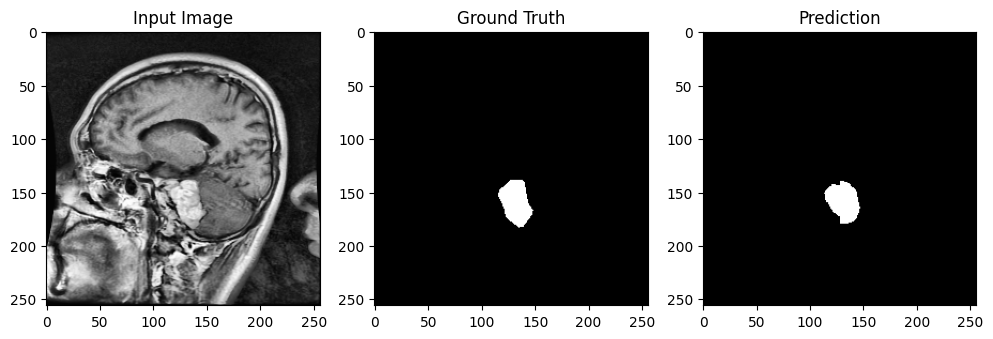

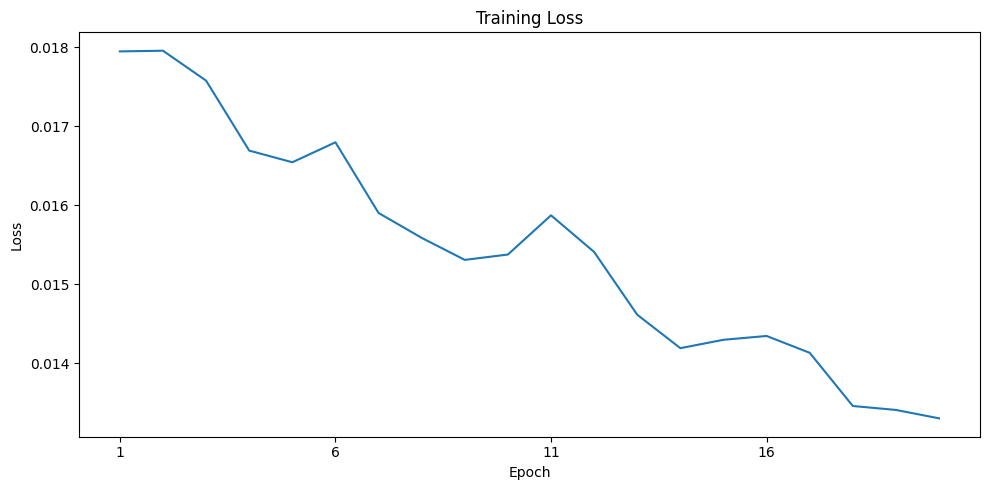

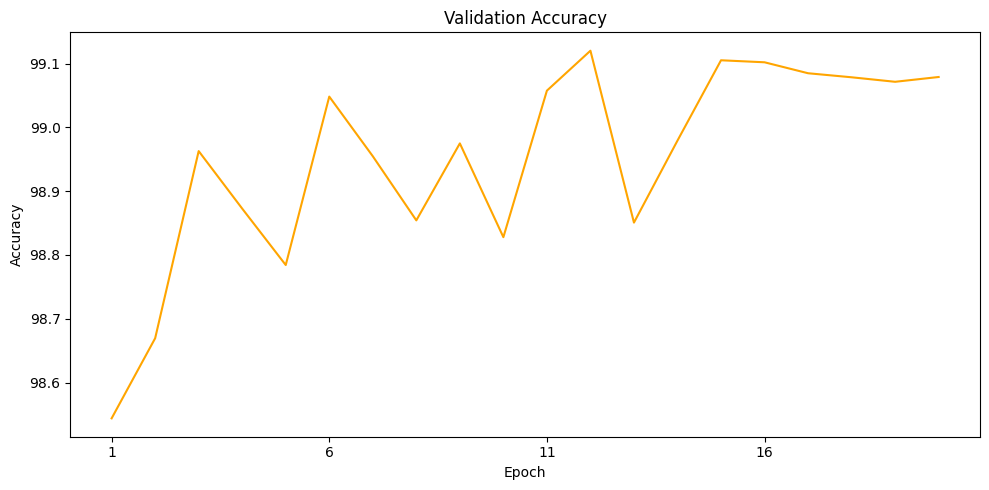

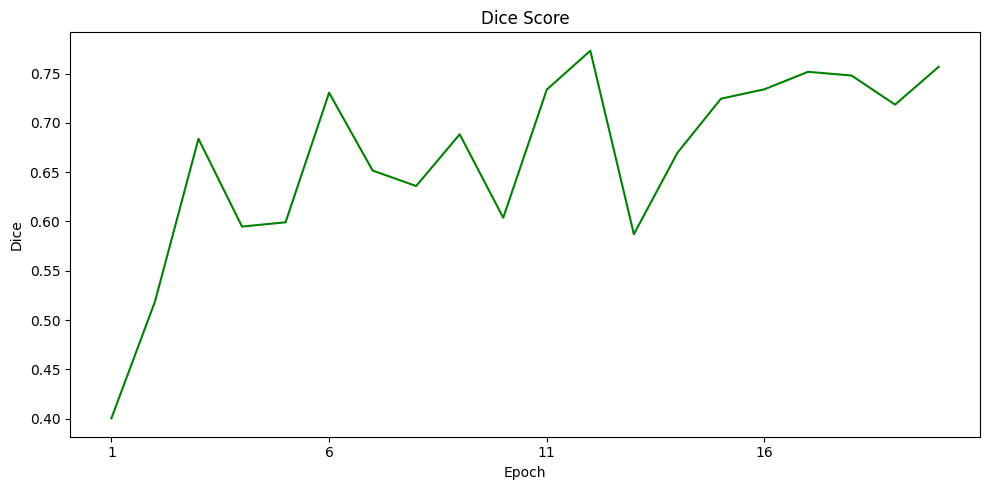

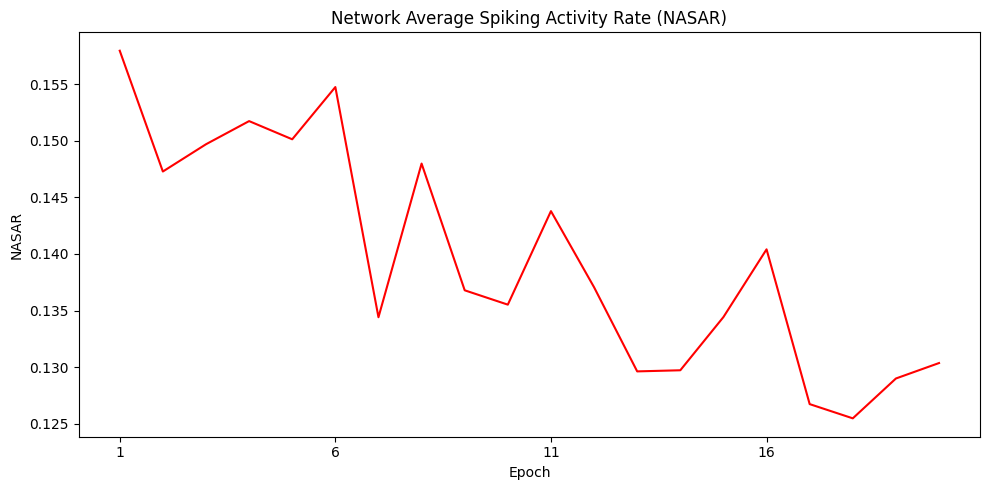

In [13]:
if __name__ == "__main__":
    main()

## Grad-CAM

In [7]:
def load_and_preprocess_image(image_path):
    transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.0), std=(1.0), max_pixel_value=255.0),
    ToTensorV2(),
    ])
    image = Image.open(image_path).convert("L")
    image_rgb = Image.open(image_path).convert("RGB")
    processed = transform(image=np.array(image))
    input_tensor = processed['image'].unsqueeze(0)
    vis_image = np.array(image_rgb.resize((256, 256))) / 255.0
    return input_tensor, vis_image

def reshape_transform_csa(tensor):
    # If tensor shape is [B, C, T, H, W], convert to [B, C*T, H, W]
    if tensor.ndim == 5:
        B, C, T, H, W = tensor.size()
        return tensor.permute(0, 2, 1, 3, 4).reshape(B, T * C, H, W)
    elif tensor.ndim == 4:
        return tensor  # Already [B, C, H, W]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

def reshape_transform_spiking(tensor):
    """Special reshape for spiking networks with attention"""
    if tensor.ndim == 5:  # [T,B,C,H,W]
        # For attention weights
        if tensor.shape[2] == 1:  # Attention mask case
            return tensor.mean(dim=0).mean(dim=1)  # [B,H,W]

        # For regular feature maps
        B, C, T, H, W = tensor.permute(1,2,0,3,4).shape
        return tensor.permute(1,0,2,3,4).reshape(B, T*C, H, W)

    elif tensor.ndim == 4:  # [B,C,H,W]
        return tensor

    raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

def generate_gradcam_grid_multi_layers(
    model,
    image_paths,
    mask_paths,
    target_layers_dict,
    device="cuda",
    save_folder="Att_Res_SNN_gradcam_results",
    grid_rows=3,
    grid_cols=6
    ):
    os.makedirs(save_folder, exist_ok=True)
    model.to(device).eval()

    selected = random.sample(list(zip(image_paths, mask_paths)), grid_rows * grid_cols)

    for layer_name, target_layer in target_layers_dict.items():

        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        layer_folder_name = f"{layer_name.replace('.', '_').replace('[', '_').replace(']', '')}_{timestamp}"
        layer_folder = os.path.join(save_folder, layer_folder_name)
        os.makedirs(layer_folder, exist_ok=True)

        cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_csa)
        # cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_spiking)

        fig_cam, axes_cam = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        fig_mask, axes_mask = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        fig_idx = 0

        for img_path, mask_path in selected:
            input_tensor, vis_image = load_and_preprocess_image(img_path)
            input_tensor = input_tensor.to(device)

            mask_tensor, _ = load_and_preprocess_image(mask_path)
            input_mask_tensor = mask_tensor.squeeze(0).cpu().numpy()

            targets = [SemanticSegmentationTarget(0, input_mask_tensor)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
            binary_seg_mask = (grayscale_cam > 0.8).astype(np.uint8)

            # Save CAM image
            cam_image = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)
            cam_save_path = os.path.join(layer_folder, f"cam_{os.path.basename(img_path)}")
            plt.imsave(cam_save_path, cam_image)

            # Save binary segmentation mask
            bin_mask_path = os.path.join(layer_folder, f"mask_{os.path.basename(img_path)}")
            plt.imsave(bin_mask_path, binary_seg_mask, cmap='gray')

            row = fig_idx // grid_cols
            col = fig_idx % grid_cols

            if row < grid_rows:
                axes_cam[row, col].imshow(cam_image)
                axes_cam[row, col].axis("off")
                axes_cam[row, col].set_title(f"{os.path.basename(img_path)}")

                axes_mask[row, col].imshow(binary_seg_mask, cmap='gray')
                axes_mask[row, col].axis("off")
                axes_mask[row, col].set_title(f"{os.path.basename(img_path)}")

                fig_idx += 1

        # Save full CAM grid
        grid_cam_path = os.path.join(layer_folder, f"grid_cam_{layer_name}_{timestamp}.png")
        plt.tight_layout()
        fig_cam.savefig(grid_cam_path)
        plt.close(fig_cam)

        # Save full binary segmentation mask grid
        grid_mask_path = os.path.join(layer_folder, f"grid_mask_{layer_name}_{timestamp}.png")
        plt.tight_layout()
        fig_mask.savefig(grid_mask_path)
        plt.close(fig_mask)

        print(f"✅ Saved {grid_cam_path}")
        print(f"✅ Saved {grid_mask_path}")

In [18]:
model = resnet_2_copy.resnet34().to(device)
checkpoint = torch.load("./Att_Res_SNN_checkpoints/Att_Res_SNN_checkpoint_24_2025-04-29_03-59-24.pth.tar", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])

image_paths = sorted(glob.glob(os.path.join(VAL_IMG_DIR, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(VAL_MASK_DIR, "*.png")))

target_layers = {
    "conv2_attention_sa": model.conv2_x[-1].residual_function[-1].attention.sa.conv,
    "conv3_attention_sa": model.conv3_x[-1].residual_function[-1].attention.sa.conv,
    # "conv4_residual":     model.conv4_x[-1].residual_function[-1],
    # "conv4":              model.conv4_x[-1],

    # "conv5_attention_sa": model.conv5_x[-1].residual_function[-1].attention.sa.conv,
    # "conv5_residual":     model.conv5_x[-1].residual_function[-1],
    # "conv5":              model.conv5_x[-1],

    # "upsampling_layer[0]": model.upsampling_layer[0],
    # "upsampling_layer[1]": model.upsampling_layer[1],
    # "upsampling_layer[2]": model.upsampling_layer[2],
    # "upsampling_layer[3]": model.upsampling_layer[3],
    # "upsampling_layer[4]": model.upsampling_layer[4],
}

generate_gradcam_grid_multi_layers(
    model=model,
    image_paths=image_paths,
    mask_paths=mask_paths,
    target_layers_dict=target_layers,
    device=device,
    save_folder="Att_Res_SNN_gradcam_results",
    grid_rows=3,
    grid_cols=6
)

✅ Saved Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/grid_cam_conv2_attention_sa_20250429-051046.png
✅ Saved Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/grid_mask_conv2_attention_sa_20250429-051046.png
✅ Saved Att_Res_SNN_gradcam_results/conv3_attention_sa_20250429-051056/grid_cam_conv3_attention_sa_20250429-051056.png
✅ Saved Att_Res_SNN_gradcam_results/conv3_attention_sa_20250429-051056/grid_mask_conv3_attention_sa_20250429-051056.png


In [19]:
from google.colab import files

!zip -r Att_Res_SNN_gradcam_results.zip Att_Res_SNN_gradcam_results
files.download('Att_Res_SNN_gradcam_results.zip')

!zip -r Att_Res_SNN_gradcam_results_old_2.zip Att_Res_SNN_gradcam_results_old_2
files.download('Att_Res_SNN_gradcam_results_old_2.zip')

# !zip -r Att_Res_SNN_saved_images.zip Att_Res_SNN_saved_images
# files.download('Att_Res_SNN_saved_images.zip')

  adding: Att_Res_SNN_gradcam_results/ (stored 0%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/ (stored 0%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/cam_16.png (deflated 0%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/cam_3031.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/cam_55.png (deflated 0%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/cam_3030.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/cam_157.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/grid_cam_conv2_attention_sa_20250429-051046.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/mask_2281.png (deflated 18%)
  adding: Att_Res_SNN_gradcam_results/conv2_attention_sa_20250429-051046/mask_3031.png (deflated 81%)
  adding: Att_Res_SNN_gradcam

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: Att_Res_SNN_gradcam_results_old_2/ (stored 0%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/ (stored 0%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/mask_242.png (deflated 68%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/cam_1527.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/cam_242.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/cam_1508.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/mask_554.png (deflated 73%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/mask_1514.png (deflated 73%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/cam_1456.png (deflated 1%)
  adding: Att_Res_SNN_gradcam_results_old_2/upsampling_layer_0_20250429-043904/mask_2685.png (deflated 73%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>